In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
import cartopy.feature as cf
import regionmask
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
ds_amz = xr.open_dataset(r'Data\Datasets\amz\map\clim\int\all.nc').drop(['spatial_ref','surface','step'])
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')
ds_amz['Region'] = regions_mask.mask(ds_amz, lon_name='lon', lat_name='lat')
dff = ds_amz.to_dataframe().reset_index().dropna().reset_index(drop=True)
dff['Region'] = dff['Region'].replace({0:'Western', 1:'Northern', 2:'Southern', 3:'Eastern'})


# compar plot

In [19]:
vmin_int = -600
vmax_int = 600
cmap_int = mpl.cm.RdBu
proj = ccrs.Mercator()
bounds_int = np.linspace(vmin_int,vmax_int,13)
norm_int = mpl.colors.BoundaryNorm(bounds_int, cmap_int.N, extend='both')
sm_int = plt.cm.ScalarMappable(cmap=cmap_int, norm=norm_int)
sm_int._A = []
extent = [-81, -42, -20, 11]

C:\Users\luisg\AppData\Local\Temp\ipykernel_10864\719769101.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


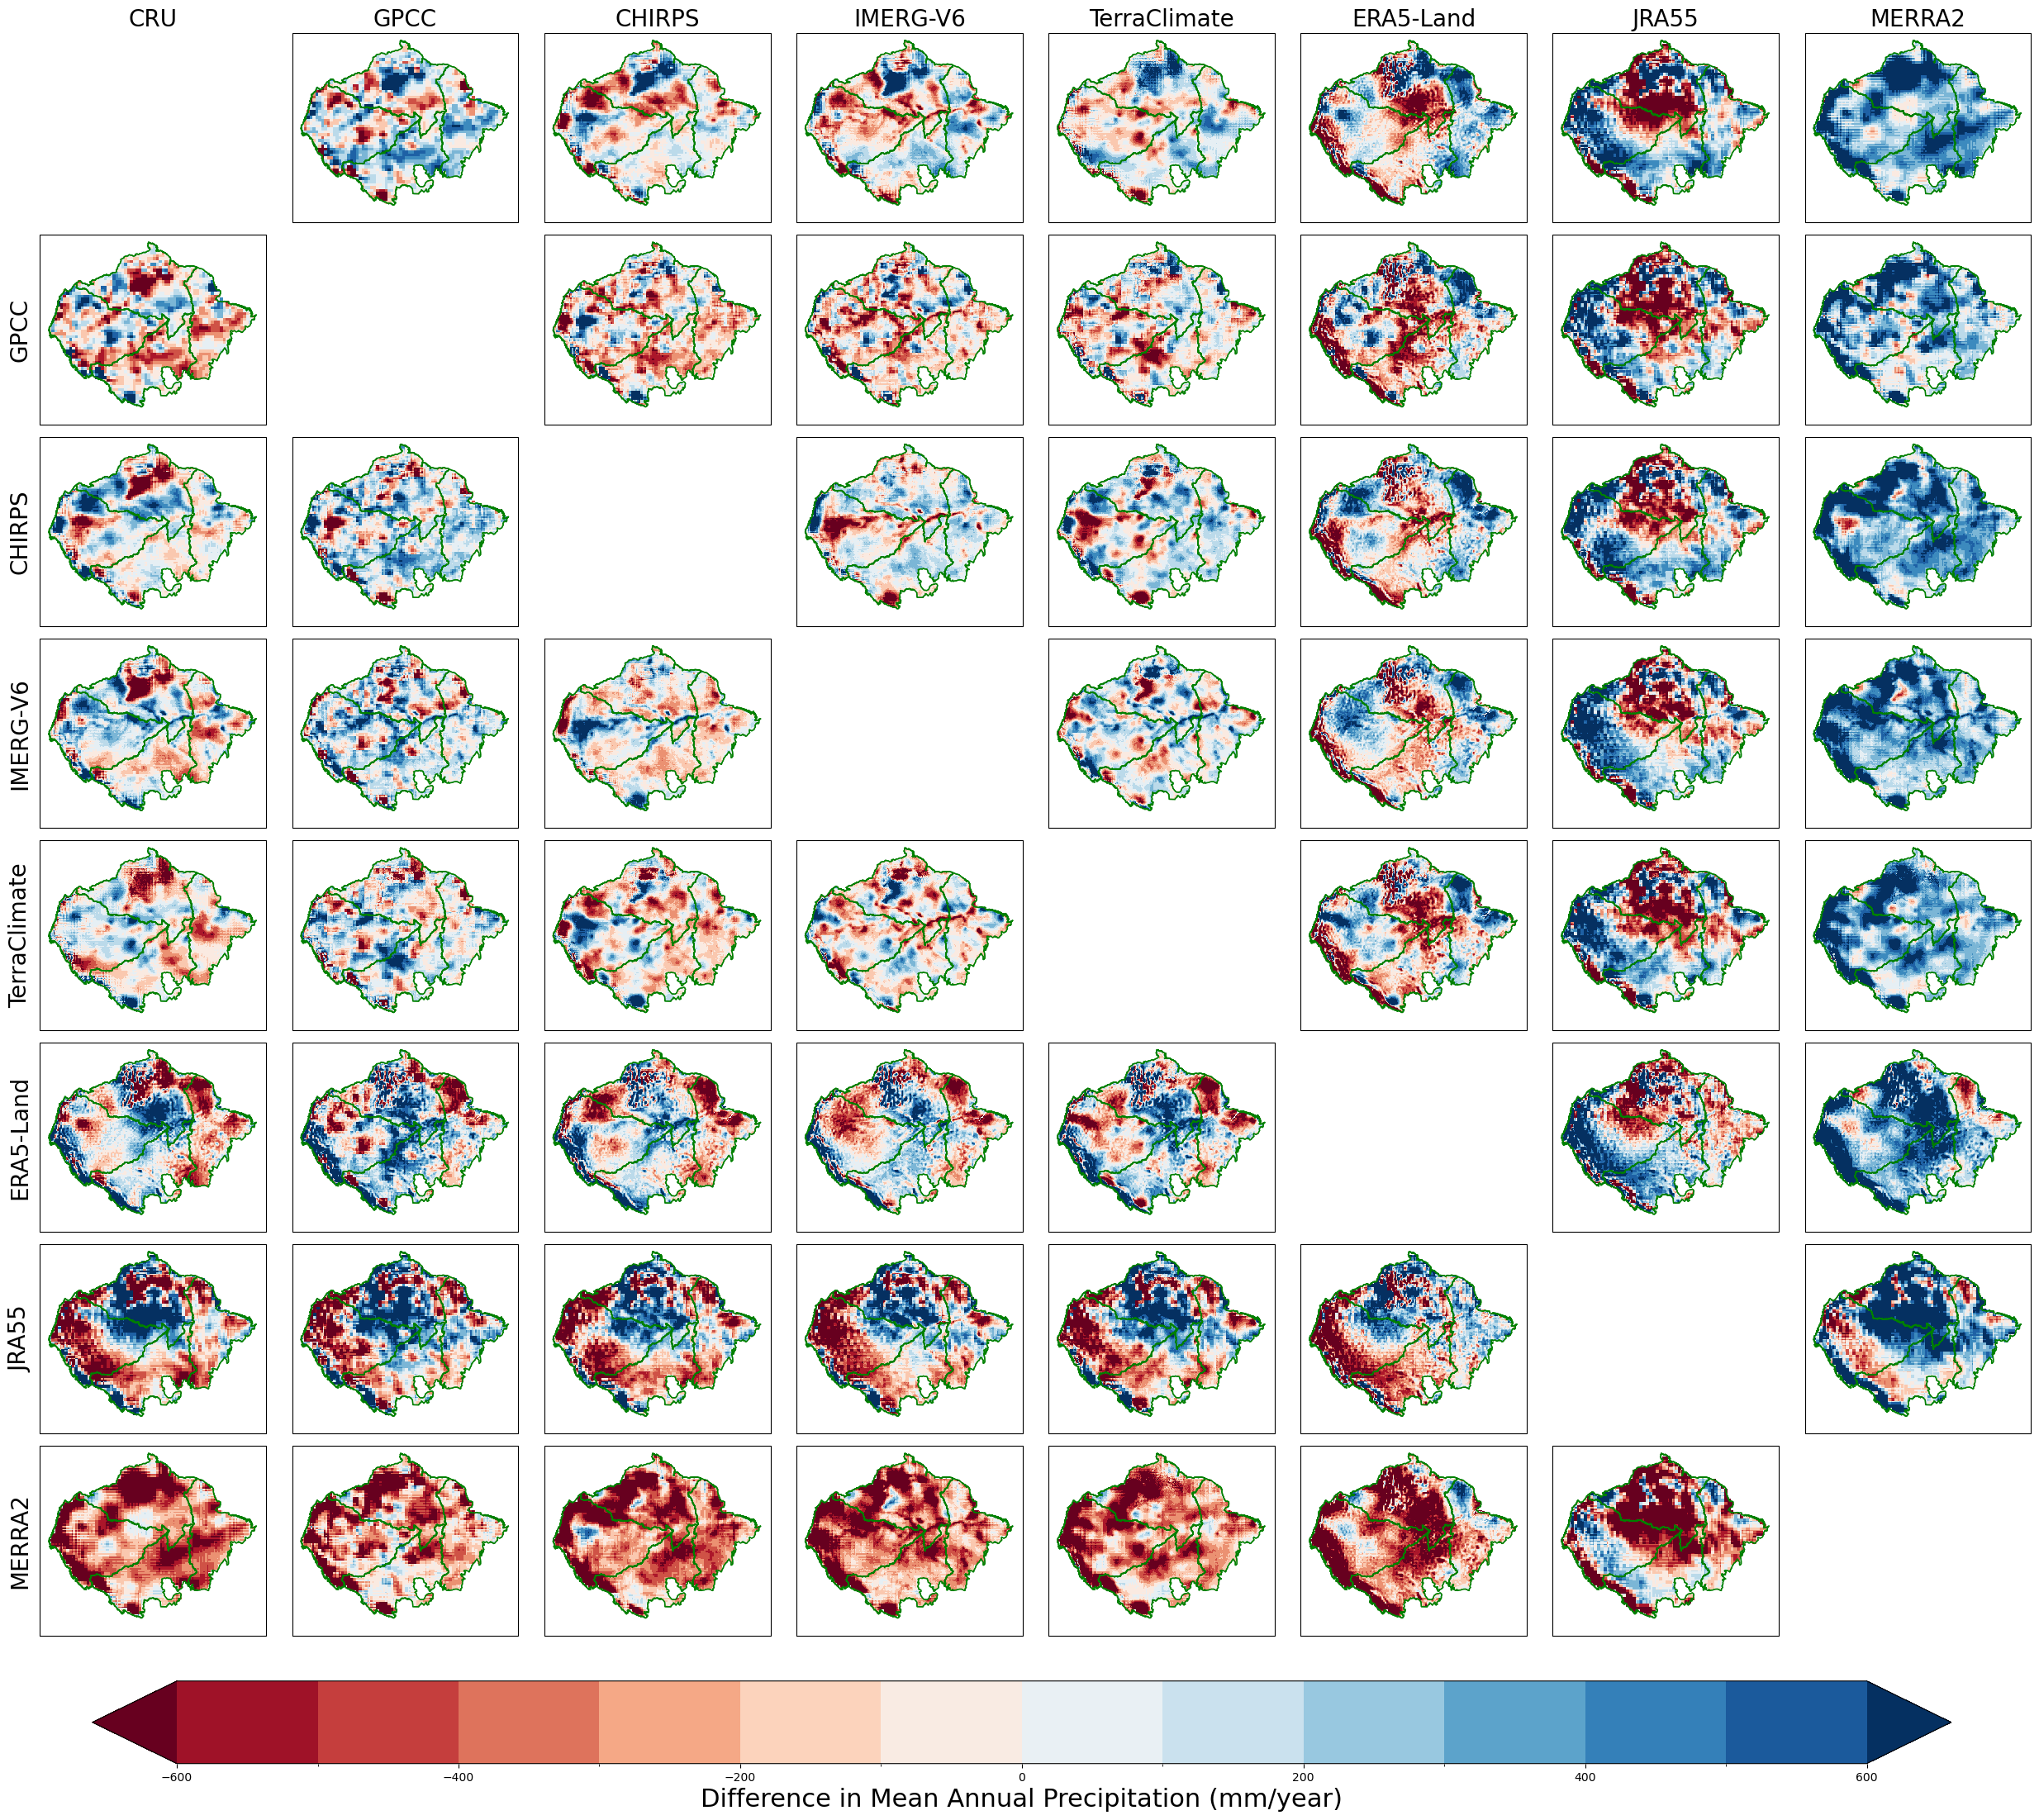

In [20]:
#plot all in one figs
fig, axes = plt.subplots(nrows=len(datasets_names), ncols=len(datasets_names), figsize=(25, 20), subplot_kw={'projection': proj})
cax = fig.add_axes([0.05, -0.07, 0.9, 0.05])
cb = fig.colorbar(sm_int, cax=cax, orientation='horizontal')
cb.set_label('Difference in Mean Annual Precipitation (mm/year)', fontsize=22)

for i, ds1_name in enumerate(datasets_names):
    for j, ds2_name in enumerate(datasets_names):
        #plot only the lower triangle
        if i != j:
            ds1 = ds_amz.isel(dataset=i)
            ds2 = ds_amz.isel(dataset=j)
            im = (ds1.pr - ds2.pr).plot(ax=axes[i, j], cmap='RdBu', vmin=vmin_int, vmax=vmax_int, add_colorbar=False, transform=ccrs.PlateCarree(), levels= 11)
            axes[i, j].add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
            #axes[i, j].add_feature(cf.BORDERS, edgecolor='grey', linewidth=0.4)    
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].set_xlabel('')
            axes[i, j].set_ylabel('')
            axes[i, j].set_extent(extent)
            axes[i, j].set_title('')
            axes[i, j].add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
            #if i == j:
            #    ds1.pr.plot(ax=axes[i, j], cmap='Blues', vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), levels= 13)
            #    axes[i, j].add_geometries(shp_amz.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
            #    axes[i, j].set_xticks([])
            #    axes[i, j].set_yticks([])
            #    axes[i, j].set_xlabel('')
            #    axes[i, j].set_ylabel('')
            #    axes[i, j].set_extent([-75, -40, -20, 6])
            #    axes[i, j].coastlines()
            ##else:
            ##    axes[i, j].axis('off')
        if i == j:
            axes[i, j].set_axis_off()

#add the names of the datasets
for i, ds in enumerate(datasets_names):
    axes[i, 0].set_ylabel(ds, fontsize=20, rotation=90)
    axes[0, i].set_title(ds, fontsize=20)
plt.tight_layout()

## pairplot

In [13]:
import regionmask
from sklearn.metrics import mean_absolute_percentage_error
regions_replace = { 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'}
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')
ds_amz['Region'] = regions_mask.mask(ds_amz, lon_name='lon', lat_name='lat')
dff = ds_amz.to_dataframe().reset_index().dropna().reset_index(drop=True)
dff['Region'] = dff['Region'].replace(regions_replace)

In [14]:
#transform dataset column into one column for each dataset
dff = dff.pivot_table(index=['lat', 'lon', 'Region'], columns='dataset', values='pr').dropna().reset_index()

In [15]:
results = []
for region in dff['Region'].unique():
    df_region = dff[dff['Region'] == region]
    for i, var1 in enumerate(datasets_names):
        for j, var2 in enumerate(datasets_names):
            if i < j:
                x = df_region[var1]
                y = df_region[var2]

                rmse = mean_squared_error(x, y, squared=False)
                mape = mean_absolute_percentage_error(x, y)
                results.append((var1, var2, region, rmse, mape))

results_df = pd.DataFrame(results, columns=['Variable 1', 'Variable 2', 'Region', 'RMSE', 'MAPE'])
#results_df.to_csv(r'Data\Datasets\Plots\results.csv', index=False)

C:\Users\luisg\AppData\Local\Temp\ipykernel_10864\2713078217.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


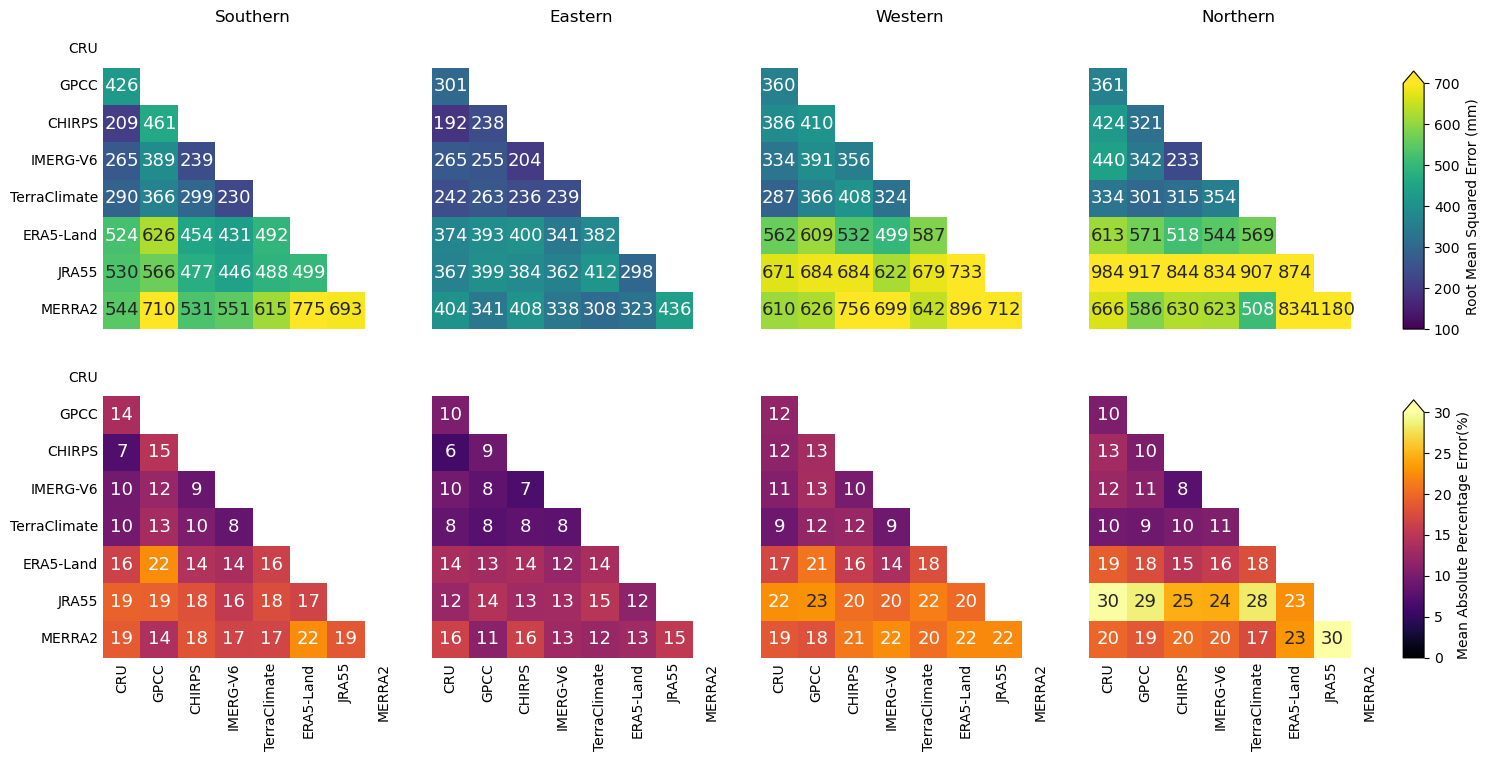

In [17]:
from mpl_toolkits.axes_grid1 import AxesGrid
fss = 13
regionss = dff['Region'].unique()
fig = plt.figure(figsize=(15, 12))
grid = AxesGrid(fig, 111,  # similar to subplot(122)
                    nrows_ncols=(2, 4),
                    axes_pad=0.30,
                    label_mode="L",
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="edge",
                    cbar_size="7%",
                    cbar_pad="5%",
                    )
for i in range(8):
        if i <= 3:
                ax = grid[i]
                region = regionss[i]
                df_region = results_df[results_df['Region'] == region]
                rmse = df_region.pivot_table(index='Variable 1', columns='Variable 2', values='RMSE').reindex(datasets_names, axis=0).reindex(datasets_names, axis=1).fillna(0).round(1)
                mask = np.triu(np.ones_like(rmse, dtype=bool))
                imr = sns.heatmap(rmse.T, annot=True, cmap='viridis', ax=ax, vmin=100, vmax=700, fmt=".0f", mask=mask, cbar=False, square=True,  annot_kws={"size": fss})
                grid.cbar_axes[0].colorbar(imr.collections[0], extend = 'max')
                ax.set_title(region)
        else:
                j = i - 4
                ax = grid[i]
                region = regionss[j]
                df_region = results_df[results_df['Region'] == region]
                mape = df_region.pivot_table(index='Variable 1', columns='Variable 2', values='MAPE').reindex(datasets_names, axis=0).reindex(datasets_names, axis=1).fillna(0).round(3)*100
                mask = np.triu(np.ones_like(mape, dtype=bool))
                ima = sns.heatmap(mape.T, annot=True, cmap='inferno', ax=ax, vmin=0, vmax=30, fmt=".0f", mask=mask, cbar=False, square=True,  annot_kws={"size": fss})
                grid.cbar_axes[1].colorbar(ima.collections[0], extend = 'max')
for ax in grid:
        ax.set_xlabel('')
        ax.set_ylabel('')
        #delete axis ticks, but labels on
        ax.tick_params(axis=u'both', which=u'both',length=0)

grid.cbar_axes[0].axis['right'].set_label("Root Mean Squared Error (mm)")
grid.cbar_axes[1].axis['right'].set_label("Mean Absolute Percentage Error(%)" )

plt.tight_layout()